In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
display(df.head())
print("\nColonnes :")
print(df.columns)
print("\nShape :", df.shape)



Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Colonnes :
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Shape : (7043, 21)


In [3]:
# 2) Détection de la colonne cible (Churn)
target_candidates = ["Churn", "churn", "Exited", "Attrition", "target", "Target"]
target = None
for c in target_candidates:
    if c in df.columns:
        target = c
        break

if target is None:
    raise ValueError(" Colonne cible introuvable. Indique le nom exact de la colonne cible.")

print("\n Colonne cible :", target)

X = df.drop(columns=[target]).copy()
y = df[target].copy()

# Si y est Yes/No -> 1/0
if y.dtype == "object":
    y = y.astype(str).str.strip().str.lower().map({"yes": 1, "no": 0, "true": 1, "false": 0})

# si mapping donne NaN, on garde y original
if pd.Series(y).isna().any():
    y = df[target].copy()


 Colonne cible : Churn


In [4]:
# 3) Valeurs manquantes : remplacer par la moyenne (colonne numérique)
import numpy as np
num_cols = X.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if X[col].isna().sum() > 0:
        X[col] = X[col].fillna(X[col].mean())

print("\n Valeurs manquantes restantes (X) :", X.isna().sum().sum())



 Valeurs manquantes restantes (X) : 0


In [5]:
# 4) Prétraitement (encodage + standardisation)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(num_cols)),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [6]:
# --- Split UNIQUE ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Colonnes
num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols = X_train.select_dtypes(exclude=np.number).columns

# Prétraitement
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])


In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [9]:
svm_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVC(probability=True, random_state=42))
])

svm_grid = {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf"],
    "model__gamma": ["scale", "auto"]
}

svm_search = GridSearchCV(
    svm_pipe,
    svm_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

svm_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy=...
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object'))])),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['linear', 'rbf']},
             scoring='f1')

In [10]:
rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

rf_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

rf_search = GridSearchCV(
    rf_pipe,
    rf_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

rf_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy=...
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [200, 400]},
             scoring='f1')

In [11]:
mlp_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", MLPClassifier(max_iter=500, random_state=42))
])

mlp_grid = {
    "model__hidden_layer_sizes": [(50,), (100,), (50,50)],
    "model__alpha": [0.0001, 0.001],
    "model__learning_rate_init": [0.001, 0.01]
}

mlp_search = GridSearchCV(
    mlp_pipe,
    mlp_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

mlp_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy=...
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object'))])),
                                       ('model',
                                        MLPClassifier(max_iter=500,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.0001, 0.001],
                         'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'model__learning_rate_init': [0.001, 0.01]},
             scoring='f1')

In [12]:
from xgboost import XGBClassifier
xgb_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        use_label_encoder=False
    ))
])
xgb_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [3, 6],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}
xgb_search = GridSearchCV(
    xgb_pipe,
    xgb_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:09:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy=...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 6],
                         'model__n_estimators': [100, 300],
                         'model__subsample': [0.8, 1.0]},
             scoring='f1')

In [13]:
models = {
    "SVM": svm_search.best_estimator_,
    "Random Forest": rf_search.best_estimator_,
    "MLP": mlp_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_
}
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Modèle": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
display(results_df)


,Modèle,Accuracy,F1-score,ROC-AUC
0,SVM,0.792761,0.581662,0.833612
1,Random Forest,0.796309,0.556414,0.826836
2,MLP,0.795600,0.563636,0.835651
3,XGBoost,0.799858,0.577844,0.839797


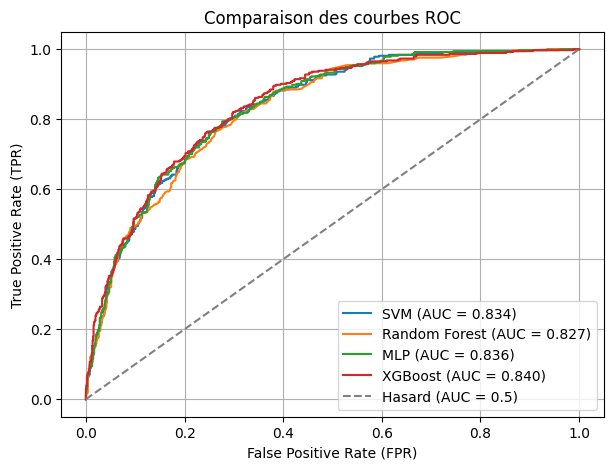

In [14]:
plt.figure(figsize=(7,5))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Ligne du hasard
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Hasard (AUC = 0.5)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Comparaison des courbes ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
